# Simple Reinforcement Learning: Exploration Strategies
This notebook contains implementations of various action-selections methods that can be used to encourage exploration during the learning process. To learn more about these methods, see the accompanying [Medium post](https://medium.com/p/d3a97b7cceaf/). Also see the interactive visualization: [here](http://awjuliani.github.io/exploration/index.html).

For more reinforcment learning tutorials see:
https://github.com/awjuliani/DeepRL-Agents

In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.contrib.slim as slim

### Load the environment

In [2]:
env = gym.make('CartPole-v0')

[2017-03-09 18:54:11,719] Making new env: CartPole-v0


## The Deep Q-Network 

### Helper functions

In [3]:
class experience_buffer():
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])
    
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

### Implementing the network itself

In [4]:
class Q_Network():
    def __init__(self):
        #These lines establish the feed-forward part of the network used to choose actions
        self.inputs = tf.placeholder(shape=[None,4],dtype=tf.float32)
        self.Temp = tf.placeholder(shape=None,dtype=tf.float32)
        self.keep_per = tf.placeholder(shape=None,dtype=tf.float32)

        hidden = slim.fully_connected(self.inputs,64,activation_fn=tf.nn.tanh,biases_initializer=None)
        hidden = slim.dropout(hidden,self.keep_per)
        self.Q_out = slim.fully_connected(hidden,2,activation_fn=None,biases_initializer=None)
        
        self.predict = tf.argmax(self.Q_out,1)
        self.Q_dist = tf.nn.softmax(self.Q_out/self.Temp)
        
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,2,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Q_out, self.actions_onehot), reduction_indices=1)
        
        self.nextQ = tf.placeholder(shape=[None],dtype=tf.float32)
        loss = tf.reduce_sum(tf.square(self.nextQ - self.Q))
        trainer = tf.train.GradientDescentOptimizer(learning_rate=0.0005)
        self.updateModel = trainer.minimize(loss)

### Training the network

In [5]:
# Set learning parameters
exploration = "e-greedy" #Exploration method. Choose between: greedy, random, e-greedy, boltzmann, bayesian.
y = .99 #Discount factor.
num_episodes = 20000 #Total number of episodes to train network for.
tau = 0.001 #Amount to update target network at each step.
batch_size = 32 #Size of training batch
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 200000 #How many steps of training to reduce startE to endE.
pre_train_steps = 50000 #Number of steps used before training updates begin.

In [ ]:
tf.reset_default_graph()

q_net = Q_Network()
target_net = Q_Network()

init = tf.initialize_all_variables()
trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables,tau)
myBuffer = experience_buffer()


#create lists to contain total rewards and steps per episode
jList = []
jMeans = []
rList = []
rMeans = []
with tf.Session() as sess:
    sess.run(init)
    updateTarget(targetOps,sess)
    e = startE
    stepDrop = (startE - endE)/anneling_steps
    total_steps = 0
    
    for i in range(num_episodes):
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        while j < 999:
            j+=1
            if exploration == "greedy":
                #Choose an action with the maximum expected value.
                a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:1.0})
                a = a[0]
            if exploration == "random":
                #Choose an action randomly.
                a = env.action_space.sample()
            if exploration == "e-greedy":
                #Choose an action by greedily (with e chance of random action) from the Q-network
                if np.random.rand(1) < e or total_steps < pre_train_steps:
                    a = env.action_space.sample()
                else:
                    a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:1.0})
                    a = a[0]
            if exploration == "boltzmann":
                #Choose an action probabilistically, with weights relative to the Q-values.
                Q_d,allQ = sess.run([q_net.Q_dist,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.Temp:e,q_net.keep_per:1.0})
                a = np.random.choice(Q_d[0],p=Q_d[0])
                a = np.argmax(Q_d[0] == a)
            if exploration == "bayesian":
                #Choose an action using a sample from a dropout approximation of a bayesian q-network.
                a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:(1-e)+0.1})
                a = a[0]
                
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a)
            myBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            
            if e > endE and total_steps > pre_train_steps:
                e -= stepDrop
            
            if total_steps > pre_train_steps and total_steps % 5 == 0:
                #We use Double-DQN training algorithm
                trainBatch = myBuffer.sample(batch_size)
                Q1 = sess.run(q_net.predict,feed_dict={q_net.inputs:np.vstack(trainBatch[:,3]),q_net.keep_per:1.0})
                Q2 = sess.run(target_net.Q_out,feed_dict={target_net.inputs:np.vstack(trainBatch[:,3]),target_net.keep_per:1.0})
                end_multiplier = -(trainBatch[:,4] - 1)
                doubleQ = Q2[range(batch_size),Q1]
                targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                _ = sess.run(q_net.updateModel,feed_dict={q_net.inputs:np.vstack(trainBatch[:,0]),q_net.nextQ:targetQ,q_net.keep_per:1.0,q_net.actions:trainBatch[:,1]})
                updateTarget(targetOps,sess)

            rAll += r
            s = s1
            total_steps += 1
            if d == True:
                break
        jList.append(j)
        rList.append(rAll)
        if i % 100 == 0 and i != 0:
            r_mean = np.mean(rList[-100:])
            j_mean = np.mean(jList[-100:])
            if exploration == 'e-greedy':
                print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " e: " + str(e))
            if exploration == 'boltzmann':
                print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " t: " + str(e))
            if exploration == 'bayesian':
                print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " p: " + str(e))
            if exploration == 'random' or exploration == 'greedy':
                print("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps))
            rMeans.append(r_mean)
            jMeans.append(j_mean)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-03-09 18:54:14,158] From <ipython-input-6-acb8f3cbe604>:6: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Mean Reward: 23.46 Total Steps: 2358 e: 1
Mean Reward: 22.23 Total Steps: 4581 e: 1
Mean Reward: 22.61 Total Steps: 6842 e: 1
Mean Reward: 21.64 Total Steps: 9006 e: 1
Mean Reward: 23.01 Total Steps: 11307 e: 1
Mean Reward: 24.09 Total Steps: 13716 e: 1
Mean Reward: 22.26 Total Steps: 15942 e: 1
Mean Reward: 22.47 Total Steps: 18189 e: 1
Mean Reward: 22.46 Total Steps: 20435 e: 1
Mean Reward: 21.97 Total Steps: 22632 e: 1
Mean Reward: 23.53 Total Steps: 24985 e: 1
Mean Reward: 23.7 Total Steps: 27355 e: 1
Mean Reward: 23.16 Total Steps: 29671 e: 1
Mean Reward: 22.42 Total Steps: 31913 e: 1
Mean Reward: 21.51 Total Steps: 34064 e: 1
Mean Reward: 21.57 Total Steps: 36221 e: 1
Mean Reward: 22.52 Total Steps: 38473 e: 1
Mean Reward: 23.16 Total Steps: 40789 e: 1
Mean Reward: 22.9 Total Steps: 43079 e: 1
Mean Reward: 22.45 Total Steps: 45324 e: 1
Mean Reward: 21.96 Total Steps: 47520 e: 1
Mean Reward: 21.72 Total Steps: 49692 e: 1
Mean Reward: 20.22 Total Steps: 51714 e: 0.9922915
Mean Rewa

### Some statistics on network performance

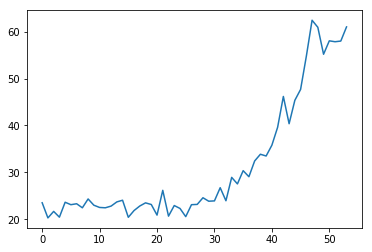

In [7]:
plt.plot(rMeans)

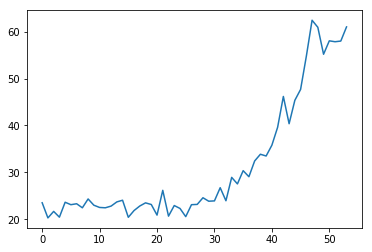

In [8]:
plt.plot(jMeans)